# Homework week 8 - lecture 15

The purpose of this notebook is to go over lecture 15 code to help with this homework assignment.

In [1]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
import seaborn as sns
import statsmodels.api as sm

import igraph
import cairocffi
from theano import tensor as tt

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

In [4]:
DATA_DIR2 = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/Data/'
df_kl = pd.read_csv(DATA_DIR2 + "KosterLeckie.csv", sep=",", header=0)
df_kl.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'A gives B'), Text(0, 0.5, 'B gives A')]

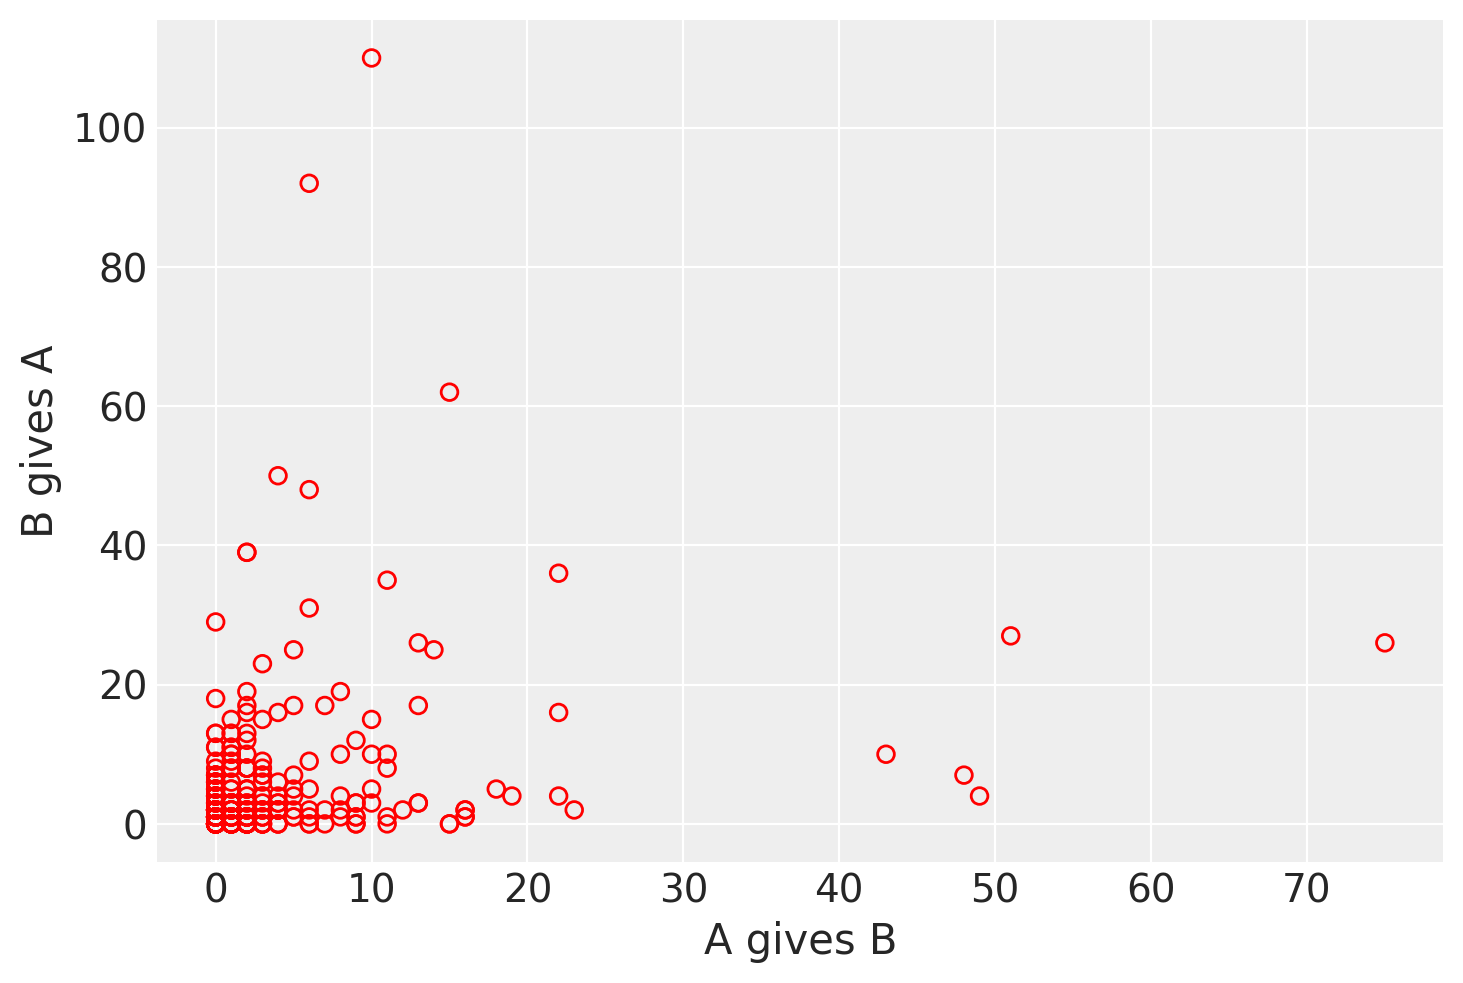

<IPython.core.display.Javascript object>

In [5]:
# slide 9

f, ax0 = plt.subplots()
ax0.scatter(df_kl['giftsAB'], df_kl['giftsBA'], facecolors='none', edgecolors='r')
ax0.set(xlabel='A gives B', ylabel='B gives A')

In [9]:
# slide 27

# N households
N = 25
dyads = pd.DataFrame(list(itertools.combinations(range(N), 2)))
# dyads = np.array(list(itertools.combinations(range(N), 2)))
N_dyads = len(dyads)

# simulate "friendships" in which ties are shared
fr = stats.bernoulli.rvs(p=0.1, size=N_dyads)  # 10% of dyads are friends
# now simulate directed ties for all individuals
# there can be ties that are not reciprocal
alpha = -3 # base rate of ties; -3 ~= 0.05

# matrix of ties
y = np.zeros((N, N))
y[y==0] = None
for i in range(N):
    for j in range(N):
        if i != j:
            # directed tie from i to j
            ids = sorted([i, j])
            the_dyad = dyads[(dyads[0]==ids[0]) & (dyads[1]==ids[1])]
            p_tie = fr[the_dyad.index] + (1-fr[the_dyad.index])*expit(alpha)  # either they're friends or they get base rate of ties
            y[i,j] = stats.bernoulli.rvs(p = p_tie, size=1)

<IPython.core.display.Javascript object>

In [10]:
dyads

,0,1
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
295,21,23
296,21,24
297,22,23
298,22,24


<IPython.core.display.Javascript object>

In [11]:
# slide 28

# now simulate gifts
giftsAB = [None] * N_dyads
giftsBA = [None] * N_dyads

lamb = np.log([0.5,2]) # rates of giving for y=0,y=1

for i in range(N_dyads):
    A = dyads.loc[i,0]
    B = dyads.loc[i,1]
    giftsAB[i] = stats.poisson.rvs( mu = np.exp( lamb[int(y[A,B])] ))
    giftsBA[i] = stats.poisson.rvs( mu = np.exp( lamb[int(y[B,A])] ))

<IPython.core.display.Javascript object>

In [12]:
# View simulated giving results
df_dyads_sim = pd.concat(
    [
        dyads,
        pd.DataFrame
        (
            {
                'giftsAB':giftsAB,
                'giftsBA':giftsBA
                }
                )
                ], axis=1
                )

df_dyads_sim

,0,1,giftsAB,giftsBA
0,0,1,1,1
1,0,2,1,2
2,0,3,0,0
3,0,4,0,0
4,0,5,1,2
...,...,...,...,...
295,21,23,0,1
296,21,24,0,2
297,22,23,1,1
298,22,24,2,0


<IPython.core.display.Javascript object>

In [122]:
# !pip install igraph
# !pip install cairocffi

<IPython.core.display.Javascript object>

In [148]:
# visualization

# import cairo

<IPython.core.display.Javascript object>

In [144]:
sng = igraph.Graph.Adjacency(y)
# lx = igraph.layout.nicely(sng)
layout = sng.layout(layout='auto')
layout

<Layout with 25 vertices and 2 dimensions>

<IPython.core.display.Javascript object>

In [390]:
# igraph.plot(sng, layout=layout)

<IPython.core.display.Javascript object>

In [13]:
N, N_dyads

(25, 300)

<IPython.core.display.Javascript object>

## Slide 34, model equation


$$ G_{AB} \sim \text{Poisson}(\lambda_{AB}) $$
$$ G_{BA} \sim \text{Poisson}(\lambda_{BA}) $$

$$ \text{log}(\lambda_{AB}) \sim \alpha + T_{AB} $$
$$ \text{log}(\lambda_{BA}) \sim \alpha + T_{BA} $$


$$ \begin{pmatrix} T_{AB} \\ T_{BA} \end{pmatrix} \sim \text{MVNormal}  \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix} , \begin{bmatrix} \sigma^2 & \rho\sigma \\ \rho\sigma & \sigma^2 \end{bmatrix} \right)    $$

$$ \rho \sim \text{LKJCorr}(2) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \alpha \sim \text{Normal}(0,1) $$

## Attempts at slide 35

In [14]:
with pm.Model() as mGD_0:
   
    # centered paramaterization
    
    ## dyad effects
    sd_dist = pm.Exponential.dist(1.0)

    # LKJCholeskyCov is more efficient than LKJCorr
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    T = pm.MvNormal("T", mu=0.0, chol=chol, shape=(N_dyads, 2))

    alpha = pm.Normal("alpha", 0, 1)
    lambdaAB = pm.Deterministic("lambdaAB", pm.math.exp(alpha + T[dyads.index, 0]))
    lambdaBA = pm.Deterministic("lambdaBA", pm.math.exp(alpha + T[dyads.index, 1]))

    G_AB = pm.Poisson("G_AB", mu = lambdaAB, observed = df_dyads_sim['giftsAB'])
    G_BA = pm.Poisson("G_BA", mu = lambdaBA, observed = df_dyads_sim['giftsBA'])

    trace_mGD_0 = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, T, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [15]:
az.summary(trace_mGD_0, var_names='T')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"T[0,0]",0.167,0.651,-0.798,1.234,0.010,0.011,4488.0,1756.0,4547.0,2530.0,1.0
"T[0,1]",0.187,0.627,-0.802,1.131,0.009,0.011,4896.0,1614.0,4962.0,2569.0,1.0
"T[1,0]",0.273,0.624,-0.755,1.231,0.009,0.010,5292.0,1818.0,5374.0,2713.0,1.0
"T[1,1]",0.529,0.598,-0.376,1.525,0.010,0.008,3694.0,2792.0,3730.0,2342.0,1.0
"T[2,0]",-0.442,0.713,-1.592,0.669,0.011,0.011,4455.0,1937.0,4532.0,2738.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"T[297,1]",0.157,0.637,-0.899,1.142,0.009,0.012,5191.0,1510.0,5226.0,2413.0,1.0
"T[298,0]",0.457,0.619,-0.505,1.428,0.010,0.008,3908.0,2693.0,3993.0,2533.0,1.0
"T[298,1]",-0.127,0.668,-1.200,0.918,0.010,0.012,4766.0,1556.0,4776.0,2734.0,1.0
"T[299,0]",-0.287,0.700,-1.402,0.814,0.010,0.012,4536.0,1746.0,4621.0,2439.0,1.0


<IPython.core.display.Javascript object>

We get estimates but sampling was poor for some parameters. Let's try non-centered.

In [16]:
with pm.Model() as mGD_1:
    
    # non-centered paramaterization
    
    ## dyad effects
    sd_dist = pm.Exponential.dist(1.0)

    # LKJCholeskyCov is more efficient than LKJCorr
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    z = pm.Normal("z", 0.0, 1.0, shape=(2, N_dyads))
    T = pm.Deterministic("T", pm.math.dot(chol, z).T)

    # linear models
    alpha = pm.Normal("alpha", 0, 1)
    lambdaAB = pm.Deterministic("lambdaAB", pm.math.exp(alpha + T[dyads.index, 0]))
    lambdaBA = pm.Deterministic("lambdaBA", pm.math.exp(alpha + T[dyads.index, 1]))

    G_AB = pm.Poisson("G_AB", mu = lambdaAB, observed = df_dyads_sim['giftsAB'])
    G_BA = pm.Poisson("G_BA", mu = lambdaBA, observed = df_dyads_sim['giftsBA'])

    trace_mGD_1 = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, z, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


<IPython.core.display.Javascript object>

In [73]:
az.summary(trace_mGD_1, var_names=['alpha', 'chol'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.584,0.082,-0.712,-0.454,0.002,0.001,2900.0,2780.0,2943.0,2408.0,1.0
chol[0],0.806,0.093,0.655,0.949,0.002,0.002,1560.0,1534.0,1576.0,1749.0,1.0
chol[1],0.352,0.135,0.147,0.579,0.004,0.003,1233.0,1233.0,1233.0,1859.0,1.0
chol[2],0.684,0.116,0.504,0.870,0.004,0.002,1093.0,1082.0,1092.0,1986.0,1.0


<IPython.core.display.Javascript object>

In [17]:
az.summary(trace_mGD_1, var_names='T')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"T[0,0]",0.178,0.649,-0.814,1.210,0.008,0.011,6752.0,1740.0,6866.0,2694.0,1.0
"T[0,1]",0.178,0.622,-0.779,1.190,0.008,0.010,5400.0,1853.0,5517.0,2516.0,1.0
"T[1,0]",0.302,0.628,-0.706,1.292,0.008,0.010,6178.0,2070.0,6176.0,2665.0,1.0
"T[1,1]",0.541,0.584,-0.410,1.437,0.008,0.007,5328.0,3233.0,5381.0,2613.0,1.0
"T[2,0]",-0.413,0.703,-1.552,0.699,0.008,0.011,7249.0,2165.0,7456.0,2768.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"T[297,1]",0.175,0.622,-0.756,1.230,0.008,0.010,6164.0,1940.0,6326.0,2704.0,1.0
"T[298,0]",0.429,0.622,-0.564,1.368,0.008,0.009,6307.0,2489.0,6527.0,2754.0,1.0
"T[298,1]",-0.104,0.658,-1.187,0.861,0.008,0.011,6806.0,1675.0,6928.0,2747.0,1.0
"T[299,0]",-0.259,0.694,-1.390,0.817,0.009,0.011,6216.0,1845.0,6348.0,2883.0,1.0


<IPython.core.display.Javascript object>

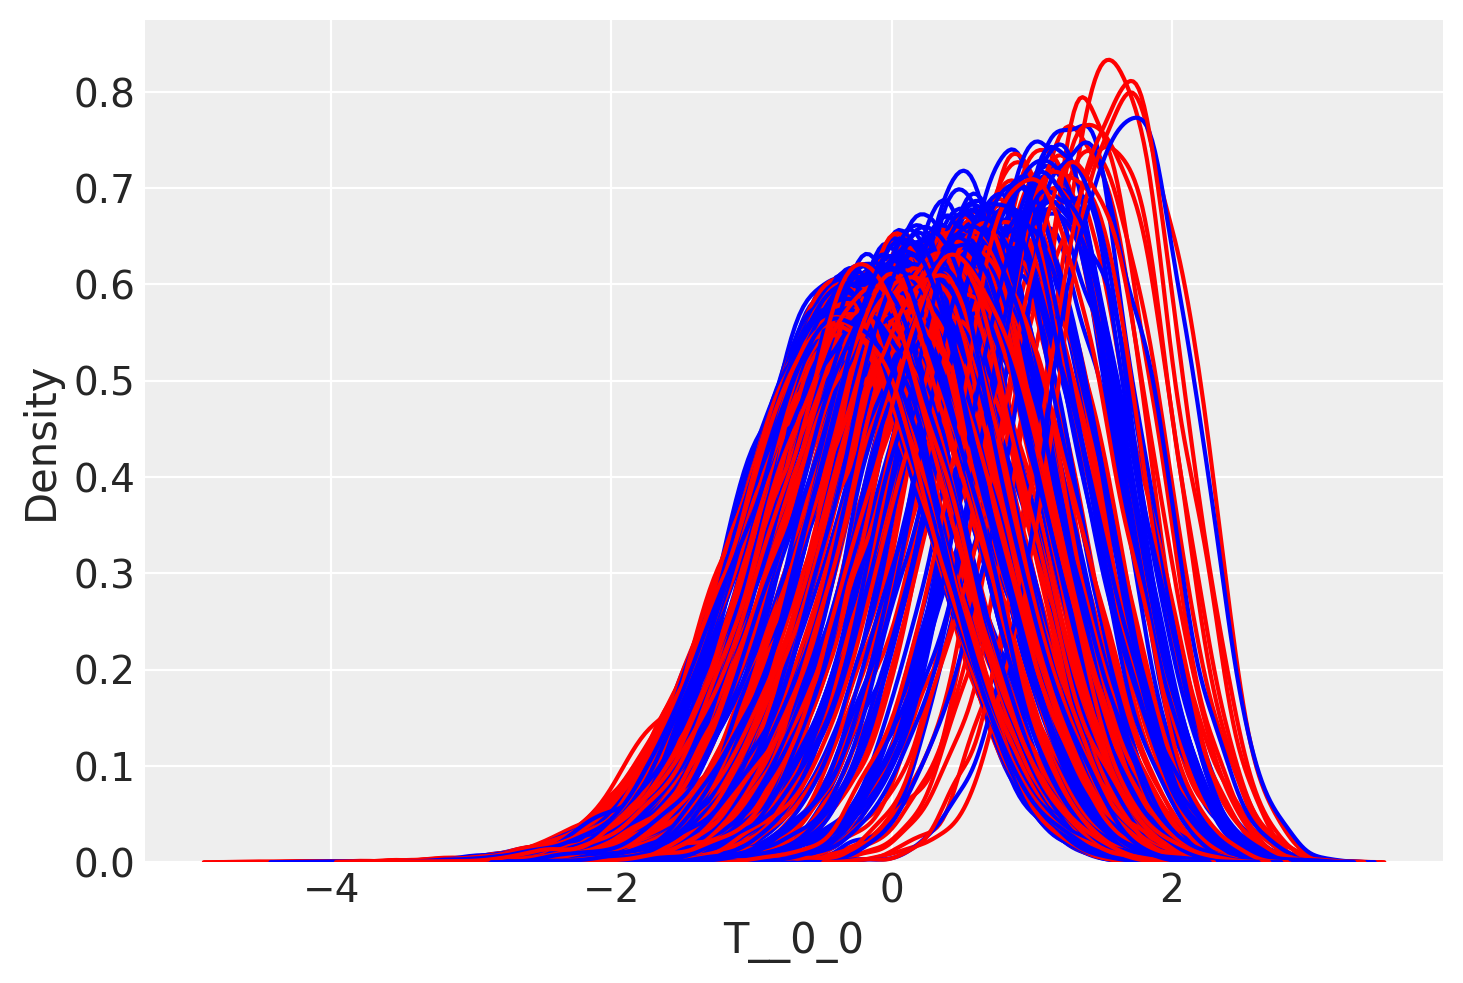

<IPython.core.display.Javascript object>

In [18]:
trace_mGD_1_df = pm.trace_to_dataframe(trace_mGD_1)
T_cols = [col for col in trace_mGD_1_df.columns if 'T__' in col]

T0_means = list()
T1_means = list()

f, ax0 = plt.subplots()
for T_col in T_cols:
    if T_col.split('T__')[1].split('_')[1] == str(0):
        sns.kdeplot(trace_mGD_1_df[T_col], ax=ax0, color='r', alpha=0.2)
        T0_means.append(trace_mGD_1_df[T_col].mean())
    if T_col.split('T__')[1].split('_')[1] == str(1):
        sns.kdeplot(trace_mGD_1_df[T_col], ax=ax0, color='b', alpha=0.2)
        T1_means.append(trace_mGD_1_df[T_col].mean())


In [19]:
T_est = pd.DataFrame({"TO":T0_means, "T1":T1_means})
T_est

,TO,T1
0,0.178220,0.178147
1,0.302161,0.540763
2,-0.412994,-0.399831
3,-0.431872,-0.418629
4,0.311140,0.555345
...,...,...
295,-0.255132,0.023049
296,-0.120573,0.424699
297,0.181193,0.175327
298,0.428608,-0.104242


<IPython.core.display.Javascript object>

In [20]:
# convert to adjacency matrix
y_est = y.copy()
for i in range(N_dyads):
    y_est[ dyads.iloc[i,0] , dyads.iloc[i,1] ] = T_est.iloc[i,0]
    y_est[ dyads.iloc[i,1] , dyads.iloc[i,0] ] = T_est.iloc[i,1]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'correlation within dyads'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'unsure if this is right')]

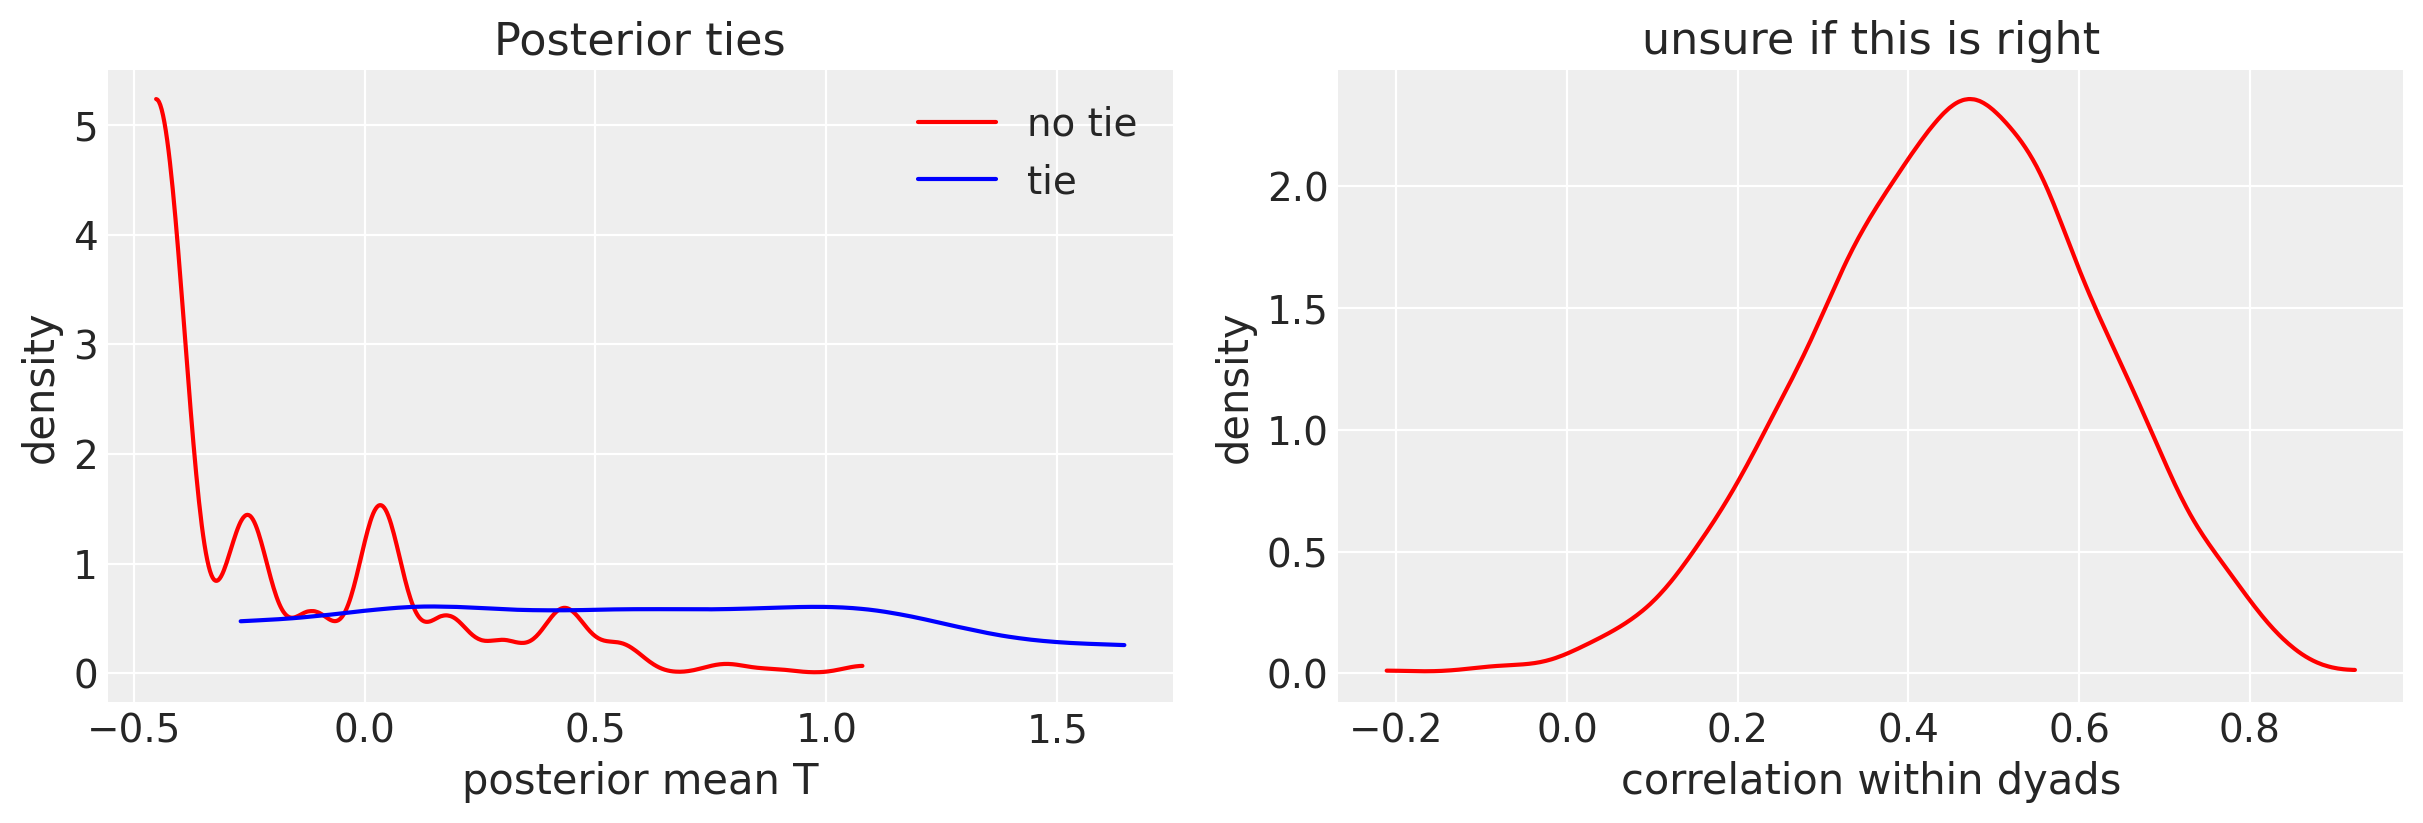

<IPython.core.display.Javascript object>

In [21]:
# slide 38

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_kde(y_est[y==0], label='no tie', plot_kwargs={"color": "red"}, ax=ax0)
az.plot_kde(y_est[y==1], label='tie', plot_kwargs={"color": "blue"}, ax=ax0)
ax0.legend()
ax0.set(xlabel='posterior mean T', ylabel='density', title='Posterior ties')

az.plot_kde(trace_mGD_1_df['chol_corr__0_1'], plot_kwargs={"color": "red"}, ax=ax1)
ax1.set(xlabel='correlation within dyads', ylabel='density', title='unsure if this is right')

In [26]:
[col for col in trace_mGD_1_df.columns if 'chol' in col]
# trace_mGD_1_df.columns 

['chol__0',
 'chol__1',
 'chol__2',
 'chol_stds__0',
 'chol_stds__1',
 'chol_corr__0_0',
 'chol_corr__0_1',
 'chol_corr__1_0',
 'chol_corr__1_1']

<IPython.core.display.Javascript object>

In [468]:
trace_mGD_1_df['chol_corr__1_0'].mean(), az.hdi(np.array(trace_mGD_1_df['chol_corr__1_0']))

(0.5367772681613076, array([0.20048785, 0.83959867]))

<IPython.core.display.Javascript object>

In [ ]:
trace_mGD_1_df['chol_corr__1_0']

In [23]:
# I believe chol[1] is supposed to be Rho
az.summary(trace_mGD_1, var_names='chol_corr')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_corr[0,1]",0.451,0.167,0.191,0.722,0.005,0.004,1109.0,1109.0,1112.0,1857.0,1.0
"chol_corr[1,0]",0.451,0.167,0.191,0.722,0.005,0.004,1109.0,1109.0,1112.0,1857.0,1.0
"chol_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3906.0,3858.0,1.0


<IPython.core.display.Javascript object>

In [27]:
az.summary(trace_mGD_1, var_names='chol')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol[0],0.806,0.093,0.655,0.949,0.002,0.002,1560.0,1534.0,1576.0,1749.0,1.0
chol[1],0.352,0.135,0.147,0.579,0.004,0.003,1233.0,1233.0,1233.0,1859.0,1.0
chol[2],0.684,0.116,0.504,0.870,0.004,0.002,1093.0,1082.0,1092.0,1986.0,1.0


<IPython.core.display.Javascript object>

# Ch 14 code

## Cafe simulation

In [6]:
from matplotlib.patches import Ellipse, transforms

<IPython.core.display.Javascript object>

In [42]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

Mu = [a, b]

<IPython.core.display.Javascript object>

In [43]:
Rmat = np.array([[1, rho], [rho, 1]])
Rmat

array([[ 1. , -0.7],
       [-0.7,  1. ]])

<IPython.core.display.Javascript object>

In [12]:
# pymc lkjcorr with eta of 2
pm.LKJCorr.dist(eta=2, n=2).random(size=5)

array([[ 0.11555357],
       [ 0.32794659],
       [-0.36670234],
       [-0.04277945],
       [ 0.03353503]])

<IPython.core.display.Javascript object>

In [8]:
cov_ab = sigma_a * sigma_b * rho
cov_ab

-0.35

<IPython.core.display.Javascript object>

In [46]:
# alternate equation
np.sqrt(sigma_a**2 * sigma_b**2) * rho

-0.35

<IPython.core.display.Javascript object>

In [47]:
Sigma = np.array([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

<IPython.core.display.Javascript object>

In [34]:
# way to generate matrix of variances and covariances, more translatable to later

# standard deviations
sigmas = [sigma_a, sigma_b]

# correlation matrix
Rho = np.matrix([[1, rho], [rho, 1]])

Rho

matrix([[ 1. , -0.7],
        [-0.7,  1. ]])

<IPython.core.display.Javascript object>

In [45]:
# matrix multiply to get covariance matrix

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

NameError: name 'Rho' is not defined

<IPython.core.display.Javascript object>

In [36]:
np.diag(sigmas)

array([[1. , 0. ],
       [0. , 0.5]])

<IPython.core.display.Javascript object>

In [48]:
N_cafes = 20
vary_effects = stats.multivariate_normal.rvs(mean=Mu, cov=Sigma, size=N_cafes)
vary_effects

array([[ 3.98430046, -0.48511839],
       [ 3.49513919, -1.05432736],
       [ 3.74825603, -1.30451419],
       [ 3.32971043, -0.95675926],
       [ 4.97237864, -1.82818455],
       [ 4.75651279, -1.26016851],
       [ 2.82484884, -0.90958166],
       [ 3.9078831 , -1.08901074],
       [ 3.88742066, -1.16463782],
       [ 4.60309173, -1.41981962],
       [ 3.60808176, -0.94888456],
       [ 1.89316196, -0.45572908],
       [ 3.40359714, -1.34228062],
       [ 3.95594861, -1.66190232],
       [ 2.78100068, -0.63564307],
       [ 3.21970512, -1.01724181],
       [ 4.15865754, -1.27592911],
       [ 2.53046089, -0.84822084],
       [ 2.81895017,  0.10113965],
       [ 3.42570969, -0.97853778]])

<IPython.core.display.Javascript object>

In [50]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'a'),
 Text(0, 0.5, 'b'),
 Text(0.5, 1.0, 'varying effects\n(samples from MV Gaussian)')]

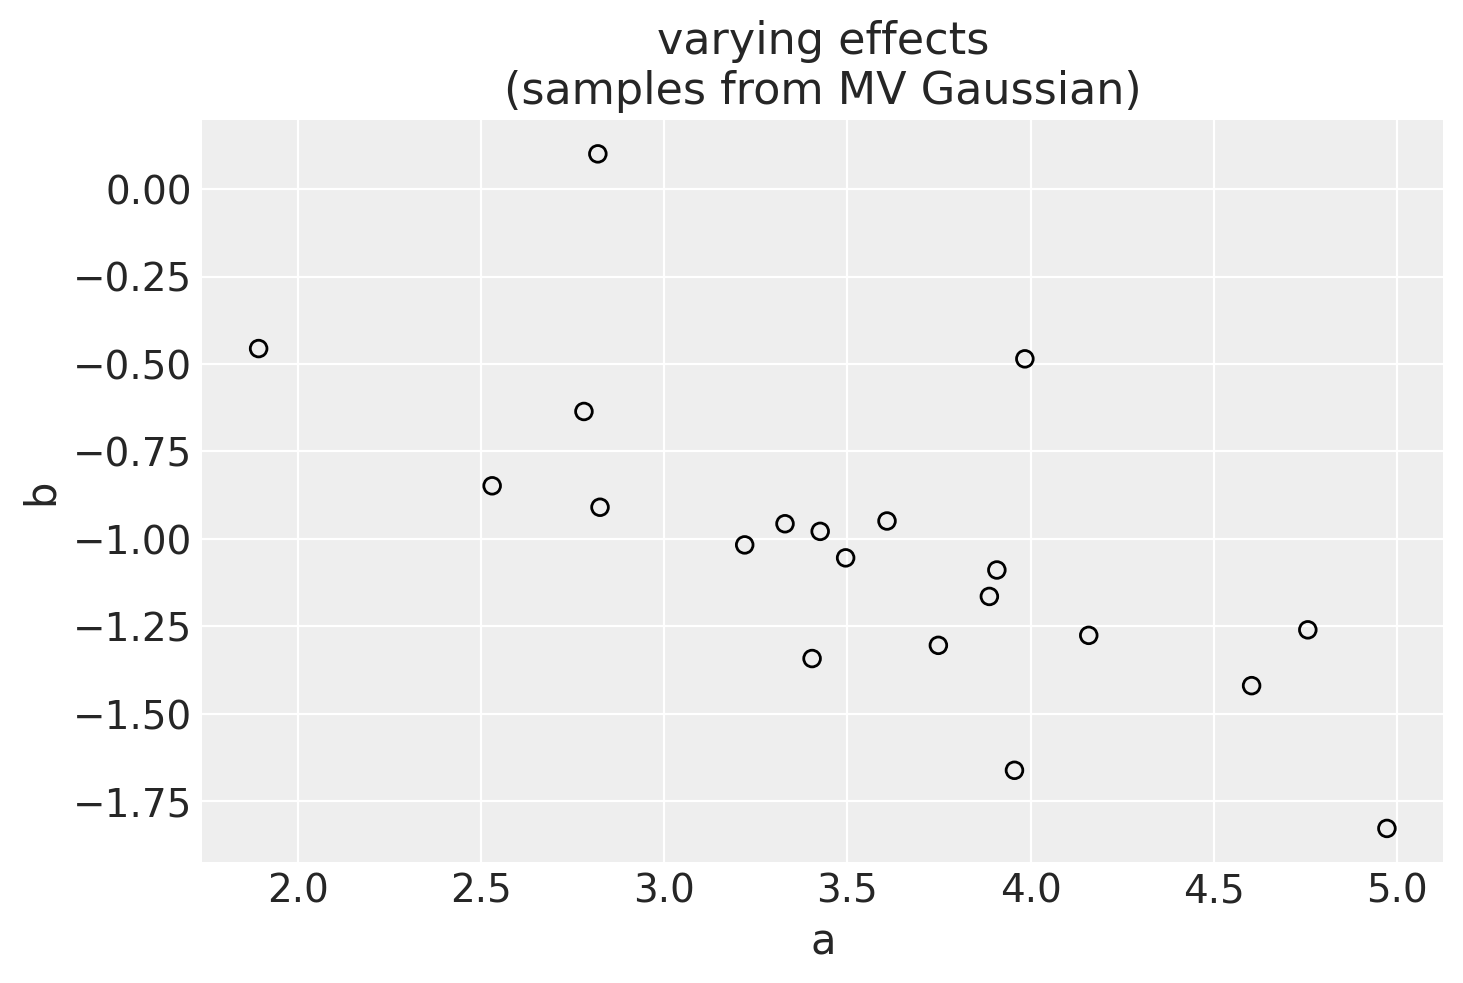

<IPython.core.display.Javascript object>

In [51]:
f, ax0 = plt.subplots()
ax0.scatter(a_cafe, b_cafe, facecolors='none', edgecolors='black')
ax0.set(xlabel='a', ylabel='b', title='varying effects\n(samples from MV Gaussian)')

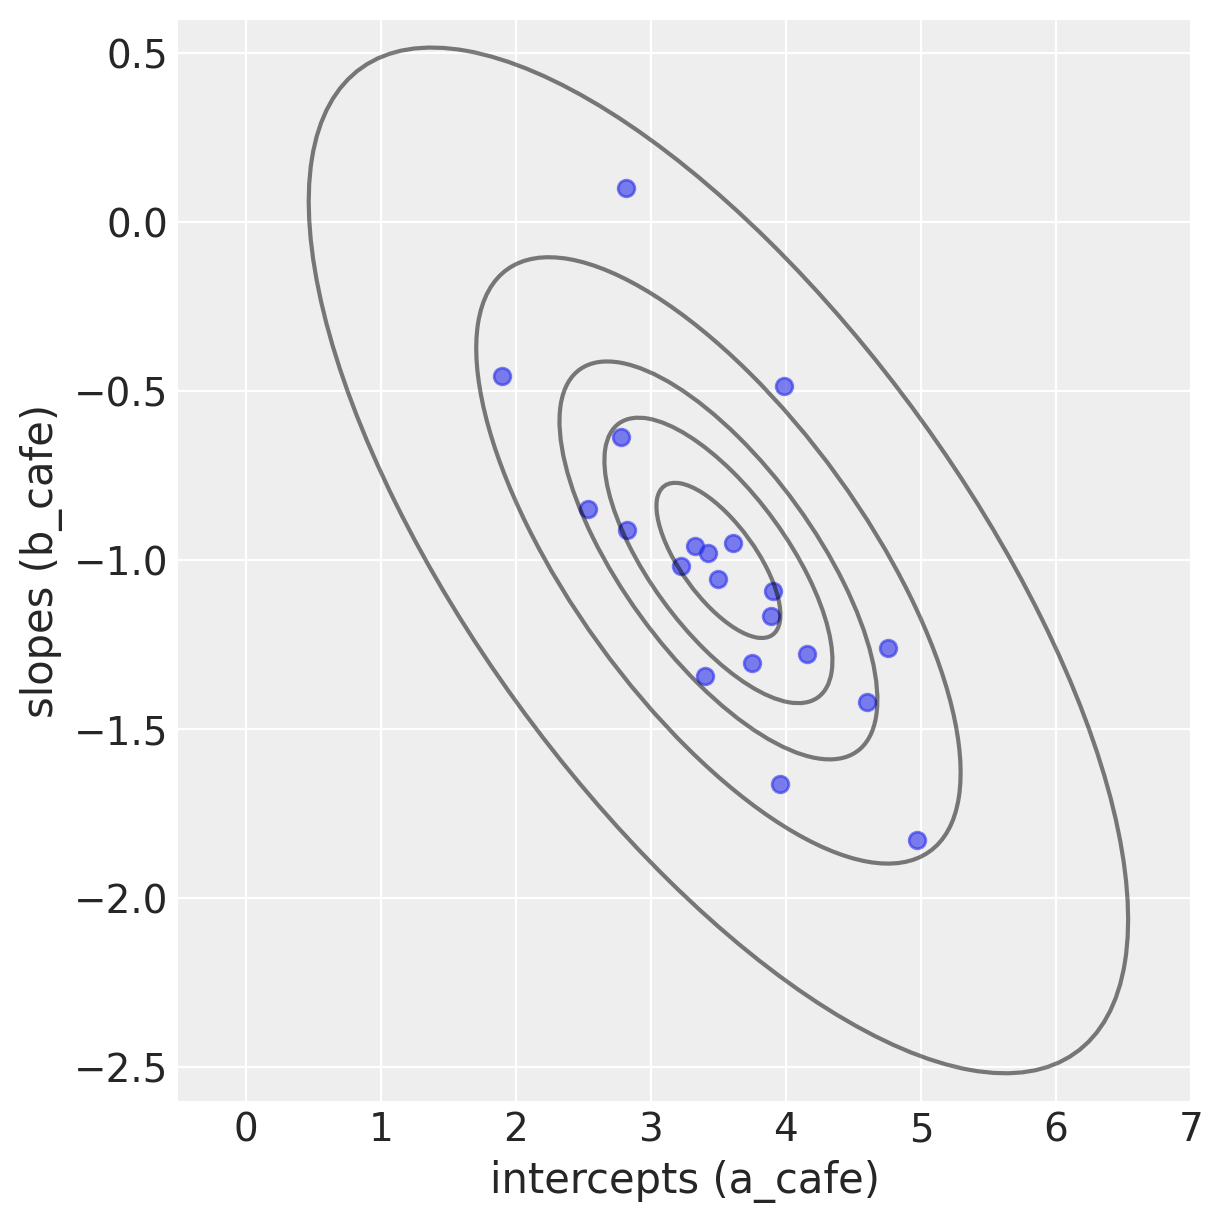

<IPython.core.display.Javascript object>

In [52]:
# repo code
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

ax = Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99])
ax.scatter(a_cafe, b_cafe, alpha=0.6)
ax.set_xlim(-0.5, 7)
ax.set_ylim(-2.6, 0.6)
ax.set_xlabel("intercepts (a_cafe)")
ax.set_ylabel("slopes (b_cafe)");

In [53]:
# simulating observations

N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d


,cafe,afternoon,wait
0,0,0,4.419218
1,0,1,4.044468
2,0,0,4.910498
3,0,1,3.805948
4,0,0,3.194937
...,...,...,...
195,19,1,2.781553
196,19,0,2.920572
197,19,1,1.767696
198,19,0,3.387296


<IPython.core.display.Javascript object>

## Cafe model

In [42]:
# rho values for 2x2 covariance matrix (smallest you can do)
pm.LKJCorr.dist(n=2, eta=2).random(size=5)

array([[ 0.41850245],
       [-0.26480722],
       [ 0.26319114],
       [-0.73448809],
       [-0.25071827]])

<IPython.core.display.Javascript object>

Where does the one unique value from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.

```
[1  a]
[a  1]
```

In [43]:
# 5 draws of rho values for 3x3 covariance matrix
pm.LKJCorr.dist(n=3, eta=2).random(size=5)

array([[ 0.39977712, -0.28989647, -0.12767101],
       [ 0.11297639,  0.16458504, -0.42417532],
       [ 0.30339437,  0.09790431,  0.0839041 ],
       [ 0.63060815,  0.21274695,  0.29531789],
       [-0.13467037,  0.28636382, -0.33153925]])

<IPython.core.display.Javascript object>

Where do the three unique values from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.
```
[1  a  b]
[a  1  c]
[b  c  1]
```

Example of cholesky decomposition [post](https://atozmath.com/example/CONM/GaussEli.aspx?he=e&q=CD2#:~:text=1.,225y%2B979z%3D1259&text=Cholesky%20decomposition%20%3A%20A%3DL%E2%8B%85,matrix%20L%20and%20its%20transpose.)

In [54]:
ax, bx, cx = pm.LKJCorr.dist(eta=2, n=3).random(size=1)[0]
ax, bx, cx

(0.11836011633697918, -0.27310877623550656, 0.09303384205027013)

<IPython.core.display.Javascript object>

In [22]:
# 3x3 Rmatrix
# matrix of Rhos (correlation coefficients)
Rmat = np.array([[1, ax, bx], [ax, 1, cx], [bx, cx, 1]])
Rmat


array([[ 1.        ,  0.47095259,  0.11311948],
       [ 0.47095259,  1.        , -0.3790755 ],
       [ 0.11311948, -0.3790755 ,  1.        ]])

<IPython.core.display.Javascript object>

In [27]:
(np.tril(Rmat) * np.tril(Rmat).T)

array([[ 1.,  0.,  0.],
       [ 0.,  1., -0.],
       [ 0., -0.,  1.]])

<IPython.core.display.Javascript object>

In [35]:
# vector of standard deviations
sigmas = stats.expon.rvs(1, size=3)

<IPython.core.display.Javascript object>

In [36]:
# bottom of page 441
np.diag(sigmas)

array([[1.44987804, 0.        , 0.        ],
       [0.        , 1.3845631 , 0.        ],
       [0.        , 0.        , 1.69949849]])

<IPython.core.display.Javascript object>

In [38]:
# covariance matrix
np.dot(np.diag(sigmas), np.dot(Rmat, np.diag(sigmas)))

array([[ 2.10214633,  0.94541266,  0.27873381],
       [ 0.94541266,  1.91701498, -0.89198849],
       [ 0.27873381, -0.89198849,  2.88829513]])

<IPython.core.display.Javascript object>

In [32]:
stats.expon.rvs(1, size=3)

array([3.30553446, 2.07249073, 1.97262965])

<IPython.core.display.Javascript object>

In [26]:
np.tril(Rmat)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.47095259,  1.        ,  0.        ],
       [ 0.11311948, -0.3790755 ,  1.        ]])

<IPython.core.display.Javascript object>

In [25]:
np.tril(Rmat).T

array([[ 1.        ,  0.47095259,  0.11311948],
       [ 0.        ,  1.        , -0.3790755 ],
       [ 0.        ,  0.        ,  1.        ]])

<IPython.core.display.Javascript object>

Can I run the model in reverse and recover the parameters?

Blog post - understanding binomial non-centered parameterization to cholesky

In [44]:
# 5 draws of rho values for 4x4 covariance matrix
pm.LKJCorr.dist(n=4, eta=2).random(size=5)

array([[-0.48722943, -0.11877992, -0.09226821,  0.16099519, -0.10953461,
        -0.16289311],
       [-0.03688666, -0.39579662, -0.54428554,  0.42601435,  0.22259753,
         0.48262832],
       [-0.14576716, -0.12772004,  0.55233718, -0.79879026,  0.05077692,
        -0.38206162],
       [-0.80971911,  0.37136914,  0.54375009,  0.00211419, -0.57520381,
        -0.0387482 ],
       [ 0.03685408,  0.01085192, -0.44455902, -0.07588314,  0.14851583,
         0.32895511]])

<IPython.core.display.Javascript object>

Where do the six unique values from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.
```
[1  a  b  c]
[a  1  d  e]
[b  d  1  f]
[c  e  f  1]
```

You really only need the upper or lower triangle to get the values for each combination.

In [45]:
for rho_i in pm.LKJCorr.dist(n=2, eta=2).random(size=5):
    print(np.diag(rho_i))

[[0.35260483]]
[[-0.57760929]]
[[-0.93377354]]
[[0.34006025]]
[[0.33628355]]


<IPython.core.display.Javascript object>

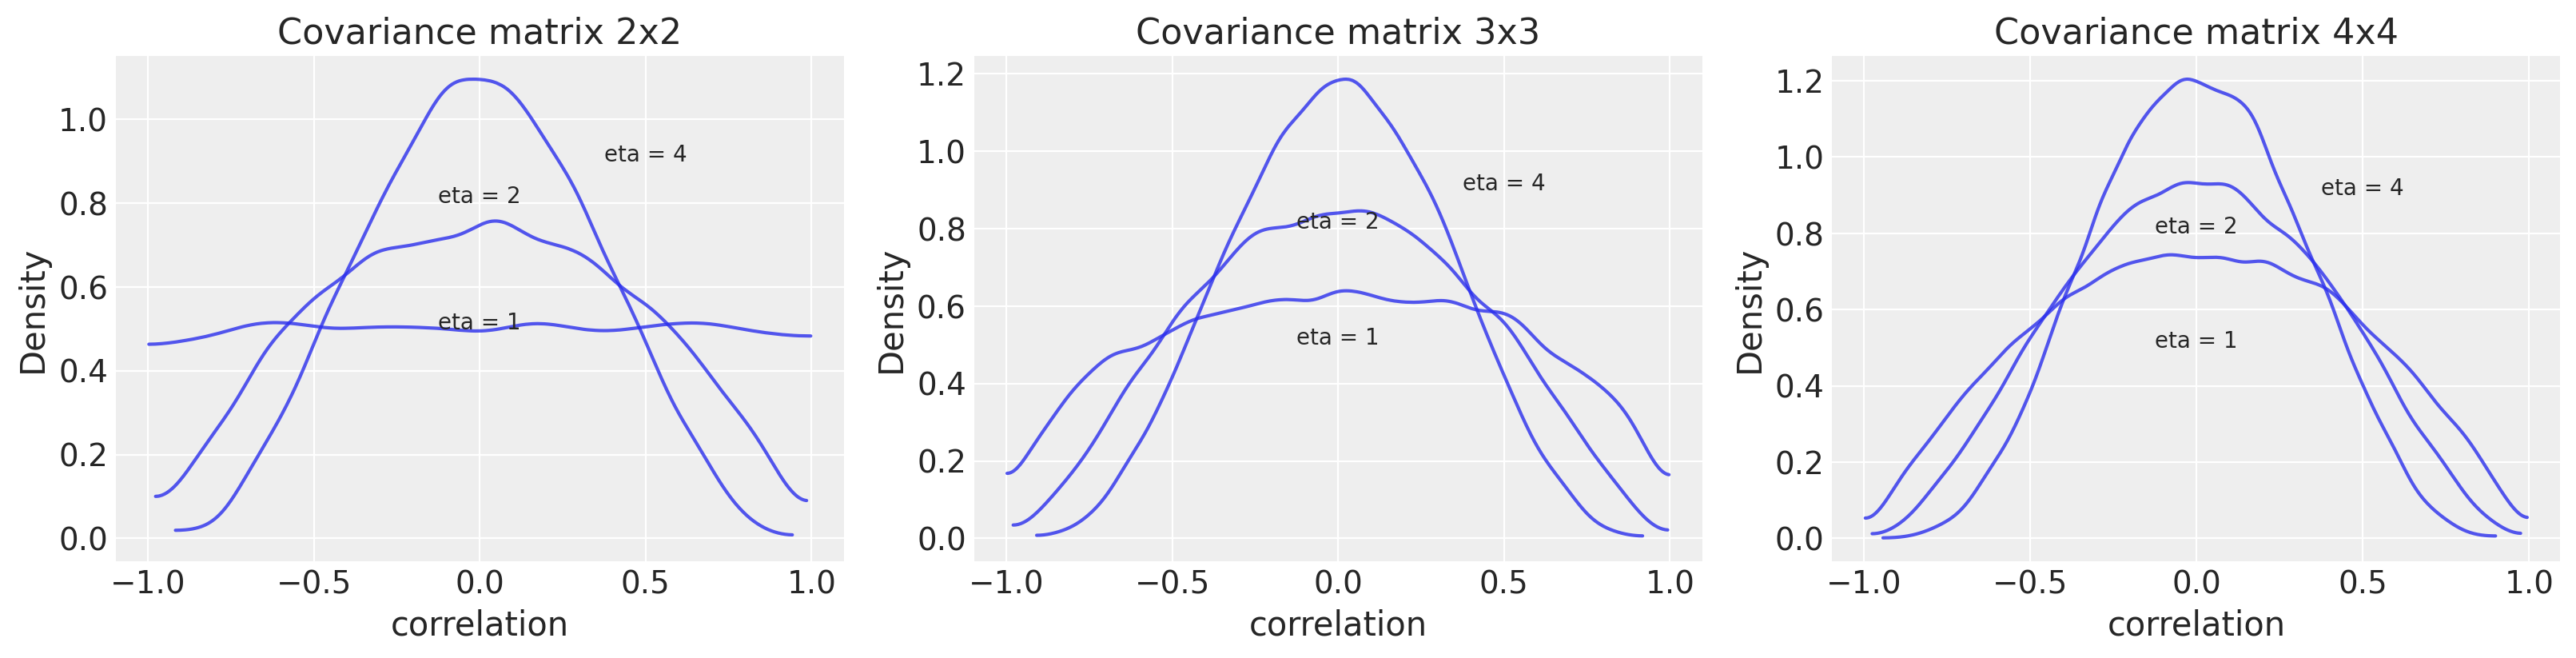

<IPython.core.display.Javascript object>

In [46]:
# repo code (for covariance matrix of 2x2)
f, ax = plt.subplots(1, 3, figsize=(16, 4))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for i in range(3):
    for eta, loc in zip([1, 2, 4], textloc):
        R = pm.LKJCorr.dist(n=i+2, eta=eta).random(size=10000)
        az.plot_kde(R, plot_kwargs={"alpha": 0.8}, ax=ax[i])
        ax[i].text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

    ax[i].set_xlabel("correlation")
    ax[i].set_ylabel("Density")
    ax[i].set_title(f"Covariance matrix {i+2}x{i+2}");

In [47]:
R.shape

(10000, 6)

<IPython.core.display.Javascript object>

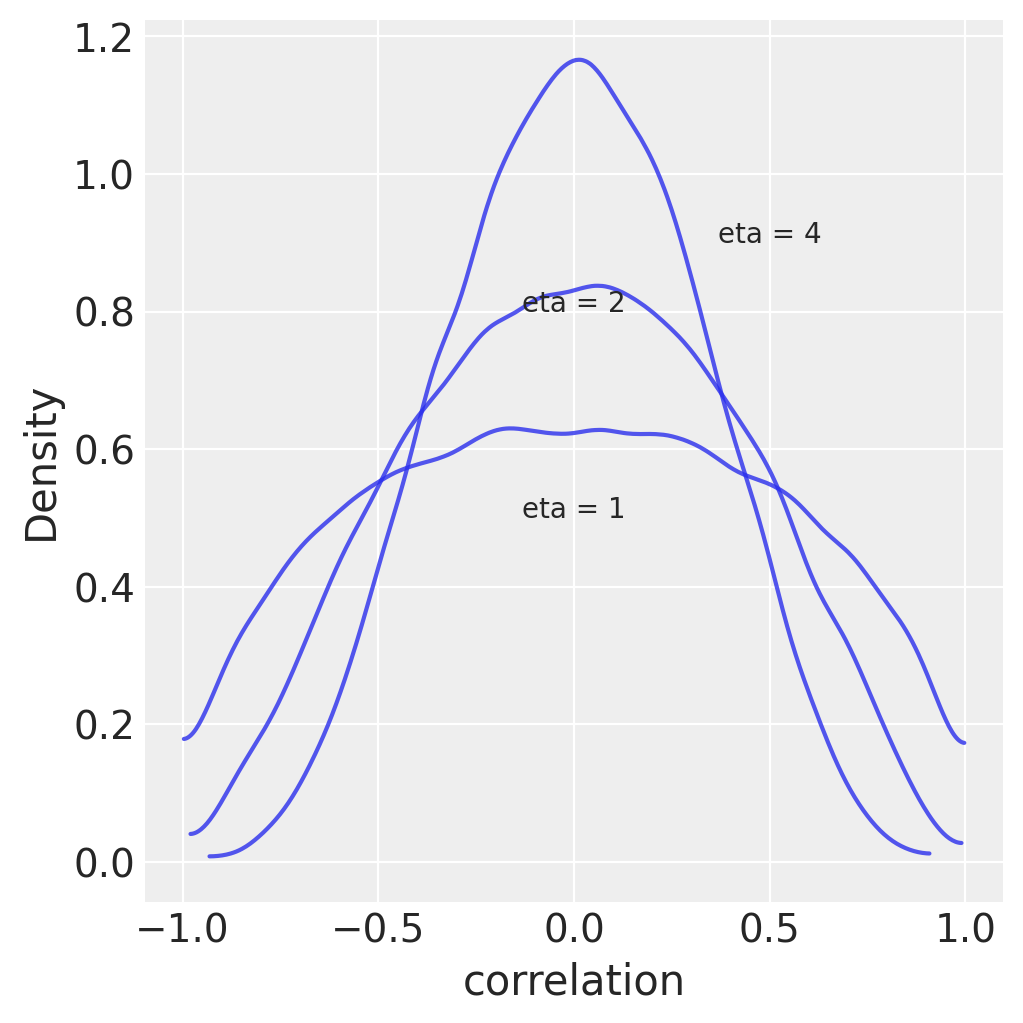

<IPython.core.display.Javascript object>

In [48]:
# repo code (for covariance matrix of 2x2)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=3, eta=eta).random(size=10000)
    az.plot_kde(R, plot_kwargs={"alpha": 0.8})
    ax.text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

`pm.LKJCorr` only returns sampled rho values. I think `LKJCholeskyCov` would return the covariance matrix?

Why are there three values for chol_cov?

1. cholesky factor
2. Rho
3. sigma

Per pymc documentation for SR: `pm.LKJCholeskyCov` "extracts the stds and matrix of correlations automatically for us"

In [349]:
# not sure why pm.LKJCholeskyCov.dist isn't working

sd_dist = pm.Exponential.dist(1.0)
#chol, Rho, sigma = 

# pm.LKJCholeskyCov.dist(
#         n=2, eta=2, sd_dist=sd_dist, compute_corr=True
#     ).random(size=1)


# pm.LKJCholeskyCov.dist(
# n=2, eta=2).random(size=1)

<IPython.core.display.Javascript object>

In [350]:
d

,cafe,afternoon,wait
0,0,0,3.252189
1,0,1,1.468280
2,0,0,3.634038
3,0,1,2.496789
4,0,0,4.314220
...,...,...,...
195,19,1,2.593629
196,19,0,4.571482
197,19,1,1.829845
198,19,0,3.294634


<IPython.core.display.Javascript object>

In [55]:
# repo code

cafe_idx = d["cafe"].values
with pm.Model() as m14_1:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", mu=5.0, sd=2.0)  # prior for average intercept
    b = pm.Normal("b", mu=-1.0, sd=0.5)  # prior for average slope
    ab_cafe = pm.MvNormal(
        "ab_cafe", mu=tt.stack([a, b]), chol=chol, shape=(N_cafes, 2)
    )  # population of varying effects
    # shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_cafe[cafe_idx, 0] + ab_cafe[cafe_idx, 1] * d["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=d["wait"].values)  # likelihood

    trace_14_1 = pm.sample(1000, tune=4000, target_accept=0.9)



/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_within, ab_cafe, b, a, chol_cov]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 144 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [57]:
# check out the posterior for rho
az.summary(trace_14_1, var_names = 'chol_cov_corr')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_cov_corr[0,1]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"chol_cov_corr[1,0]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"chol_cov_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3922.0,3864.0,1.0


<IPython.core.display.Javascript object>

In [58]:

# See renaming here to see what each variable refers to
idata_14_1 = az.from_pymc3(
        trace_14_1,
        dims={"ab_cafe": ["cafe_nbr", "var_effect"]},
        coords={
            "chol_cov_stds_dim_0": ["intercepts", "slopes"],
            "var_effect": ["intercepts", "slopes"],
        },
    )
post = idata_14_1.posterior = idata_14_1.posterior.rename_vars(
    {"chol_cov_corr": "Rho", "chol_cov_stds": "sigma_cafe"}
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<IPython.core.display.Javascript object>

In [59]:
az.summary(idata_14_1, var_names='Rho')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"Rho[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Rho[0,1]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"Rho[1,0]",-0.546,0.224,-0.877,-0.223,0.004,0.003,2681.0,2681.0,2686.0,2816.0,1.0
"Rho[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3922.0,3864.0,1.0


<IPython.core.display.Javascript object>

In [60]:
az.summary(idata_14_1, var_names='sigma_cafe')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_cafe[0],0.759,0.140,0.540,0.964,0.003,0.002,2885.0,2739.0,2896.0,2149.0,1.00
sigma_cafe[1],0.355,0.121,0.152,0.531,0.004,0.003,752.0,752.0,685.0,634.0,1.01


<IPython.core.display.Javascript object>

In [69]:
# correlation matrix of first sample from posterior
np.array(post['Rho'][0][0])

array([[ 1.        , -0.73483927],
       [-0.73483927,  1.        ]])

<IPython.core.display.Javascript object>

In [70]:
# covariance matrix of second sample from posterior
np.array(post['Rho'][0][1])

array([[ 1.        , -0.65753021],
       [-0.65753021,  1.        ]])

<IPython.core.display.Javascript object>

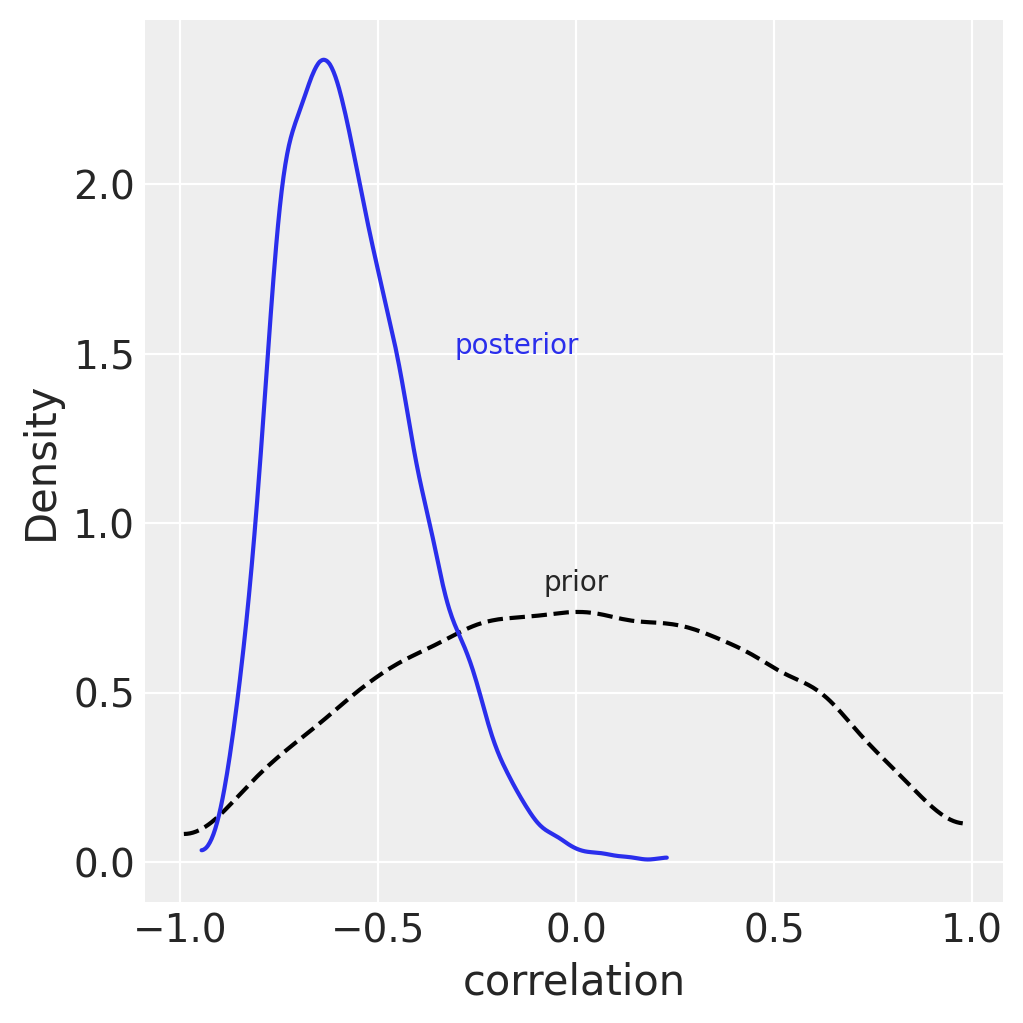

<IPython.core.display.Javascript object>

In [71]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
az.plot_kde(R, plot_kwargs={"color": "k", "linestyle": "--"})
ax.text(0, 0.8, "prior", horizontalalignment="center")

az.plot_kde(
    post["Rho"].sel(chol_cov_corr_dim_0=1, chol_cov_corr_dim_1=0),
    plot_kwargs={"color": "C0"},
)
ax.text(-0.15, 1.5, "posterior", color="C0", horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

## Dyads book code

In [381]:
kl_dyads = df_kl.copy()
N = len(kl_dyads)
N_households = kl_dyads.hidB.max()
did = (kl_dyads.did - 1).values
hidA = (kl_dyads.hidA - 1).values
hidB = (kl_dyads.hidB - 1).values

<IPython.core.display.Javascript object>

In [374]:
did


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

<IPython.core.display.Javascript object>

In [375]:
with pm.Model() as m14_7:
    ## gr matrix of varying effects
    sd_dist = pm.Exponential.dist(1.0)
    chol_gr, _, _ = pm.LKJCholeskyCov("chol_gr", n=2, eta=4, sd_dist=sd_dist, compute_corr=True)
    gr = pm.MvNormal("gr", mu=0.0, chol=chol_gr, shape=(N_households, 2))

    ## dyad effects
    chol_dyad, _, _ = pm.LKJCholeskyCov("chol_dyad", n=2, eta=8, sd_dist=sd_dist, compute_corr=True)
    z = pm.Normal("z", 0.0, 1.0, shape=(2, N))
    d = pm.Deterministic("d", pm.math.dot(chol_dyad, z).T)

    # linear models
    a = pm.Normal("a", mu=0.0, sd=1.0)
    lambdaAB = pm.math.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = pm.math.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])

    giftsAB = pm.Poisson("giftsAB", lambdaAB, observed=kl_dyads.giftsAB)
    giftsBA = pm.Poisson("giftsBA", lambdaBA, observed=kl_dyads.giftsBA)

    trace_14_7 = pm.sample(2000, tune=3000, random_seed=RANDOM_SEED)
    idata_14_7 = az.from_pymc3(
        trace_14_7,
        dims={"d": ["Dyad", "House"], "gr": ["Household", "Rate"]},
        coords={"Rate": ["giving", "receiving"]},
    )
post_14_7 = idata_14_7.posterior = idata_14_7.posterior.rename_vars(
    {
        "chol_gr_corr": "Rho_gr",
        "chol_gr_stds": "sigma_gr",
        "chol_dyad_corr": "Rho_d",
        "chol_dyad_stds": "sigma_d",
    }
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, z, chol_dyad, gr, chol_gr]
INFO:pymc3:NUTS: [a, z, chol_dyad, gr, chol_gr]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 279 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 279 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [377]:
# az.summary(trace_14_7)

<IPython.core.display.Javascript object>

In [378]:
az.summary(idata_14_7, var_names=["Rho_gr", "sigma_gr"], round_to=2)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"Rho_gr[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,8000.00,8000.00,8000.00,8000.00,NaN
"Rho_gr[0,1]",-0.42,0.20,-0.73,-0.12,0.0,0.0,2853.60,2780.63,2781.46,4239.92,1.0
"Rho_gr[1,0]",-0.42,0.20,-0.73,-0.12,0.0,0.0,2853.60,2780.63,2781.46,4239.92,1.0
"Rho_gr[1,1]",1.00,0.00,1.00,1.00,0.0,0.0,8000.00,8000.00,8318.25,8000.00,1.0
sigma_gr[0],0.83,0.14,0.62,1.04,0.0,0.0,5087.16,4986.74,5283.08,5190.87,1.0
sigma_gr[1],0.41,0.09,0.27,0.55,0.0,0.0,1905.32,1905.32,1825.35,2711.64,1.0


<IPython.core.display.Javascript object>

In [380]:
g = (post_14_7["a"] + post_14_7["gr"].sel(Rate="giving")).stack(sample=("chain", "draw"))
r = (post_14_7["a"] + post_14_7["gr"].sel(Rate="receiving")).stack(sample=("chain", "draw"))
Eg_mu = np.exp(g).mean(dim="sample")
Er_mu = np.exp(r).mean(dim="sample")

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>